In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hindi-sentence/data_sentence.csv


In [2]:
df = pd.read_csv("/kaggle/input/hindi-sentence/data_sentence.csv")

In [3]:
df.head()


,source,target
0,भूमंढलीय ऊस्मीकरण का अर्थ पृथ्वी की निकटस्थसतह...,भूमंडलीय ऊष्मीकरण का अर्थ पृथ्वी की निकटस्थसतह...
1,पृथ्वी की सतह के निकट विस्व की वायू के औसत् ता...,पृथ्वी की सतह के निकट विश्व की वायु के औसत ताप...
2,जलवायू परिवर्तन पर बैठे अंतरसरकार पैनल ने निस्...,जलवायु परिवर्तन पर बैठे अंतरसरकार पैनल ने निष्...
3,जैसा कि नाम से ही स्पस्ट है धरती के वातावरण के...,जैसा कि नाम से ही स्पष्ट है धरती के वातावरण के...
4,हमारी धरती सूरय की किरणों से उस्मा प्रराप्त् क...,हमारी धरती सूर्य की किरणों से उष्मा प्राप्त कर...


In [4]:
df.dropna(inplace = True)

In [5]:
df['src_len'] = df['source'].apply(lambda x : len(x.split(" ")))

In [6]:
df = df[df['src_len'] <= 10]

In [7]:
df.head()

,source,target,src_len
4,हमारी धरती सूरय की किरणों से उस्मा प्रराप्त् क...,हमारी धरती सूर्य की किरणों से उष्मा प्राप्त कर...,10
22,बाध्यता का कोयी भी प्ररभाव तात्कालिक् नहीं है,बाध्यता का कोई भी प्रभाव तात्कालिक नहीं है,8
99,से निपटने के लिये अपने प्ररयास दूगने कर दे,से निपटने के लिए अपने प्रयास दुगने कर दे,9
104,में परिवर्तन सामिल है,में परिवर्तन शामिल है,4
105,में परिवर्तन है,में परिवर्तन है,3


In [8]:
df['target'] = '[start] ' + df['target'] + ' [end]'

In [9]:
src = df['source']
tar = df['target']

src_max_len = max(len(line.split()) for line in src)
tar_max_len = max(len(line.split()) for line in tar)
sequence_len = max(src_max_len, tar_max_len)

print(f'Max phrase length (Source): {src_max_len}')
print(f'Max phrase length (Target): {tar_max_len}')
print(f'Sequence length: {sequence_len}')

Max phrase length (Source): 10
Max phrase length (Target): 12
Sequence length: 12


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(src)
src_sequences = src_tokenizer.texts_to_sequences(src)
src_x = pad_sequences(src_sequences, maxlen=sequence_len, padding='post')

tar_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n')
tar_tokenizer.fit_on_texts(tar)
tar_sequences = tar_tokenizer.texts_to_sequences(tar)
tar_y = pad_sequences(tar_sequences, maxlen=sequence_len + 1, padding='post')

In [11]:
src_vocab_size = len(src_tokenizer.word_index) + 1
tar_vocab_size = len(tar_tokenizer.word_index) + 1

print(f'Vocabulary size (source): {src_vocab_size}')
print(f'Vocabulary size (target): {tar_vocab_size}')

Vocabulary size (source): 61526
Vocabulary size (target): 62389


In [12]:
inputs = { 'encoder_input': src_x, 'decoder_input': tar_y[:, :-1] }
outputs = tar_y[:, 1:]

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from keras_nlp.layers import TokenAndPositionEmbedding, TransformerEncoder
from keras_nlp.layers import TransformerDecoder

np.random.seed(42)
tf.random.set_seed(42)

num_heads = 8
embed_dim = 256

encoder_input = Input(shape=(None,), dtype='int64', name='encoder_input')
x = TokenAndPositionEmbedding(src_vocab_size, sequence_len, embed_dim)(encoder_input)
encoder_output = TransformerEncoder(embed_dim, num_heads)(x)
encoded_seq_input = Input(shape=(None, embed_dim))

decoder_input = Input(shape=(None,), dtype='int64', name='decoder_input')
x = TokenAndPositionEmbedding(tar_vocab_size, sequence_len, embed_dim, mask_zero=True)(decoder_input)
x = TransformerDecoder(embed_dim, num_heads)(x, encoded_seq_input)
x = Dropout(0.4)(x)

decoder_output = Dense(tar_vocab_size, activation='softmax')(x)
decoder = Model([decoder_input, encoded_seq_input], decoder_output)
decoder_output = decoder([decoder_input, encoder_output])

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary(line_length=120)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ encoder_input (InputLayer)        │ (None, None)                 │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ token_and_position_embedding      │ (None, None, 256)            │        15,753,728 │ encoder_input[0][0]       
│ (TokenAndPositionEmbedding)       │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ decoder_input (InputLayer)        │ (None, None)                 │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ transformer_encoder               │ (None, None, 256)            │           395,776 │ token_and_position_embeddi
│ (TransformerEncoder)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ functional_1 (Functional)         │ (None, None, 62389)          │        32,668,085 │ decoder_input[0][0],      
│                                   │                              │                   │ transformer_encoder[0][0] 
└───────────────────────────────────┴──────────────────────────────┴───────────────────┴───────────────────────────

 Total params: 48,817,589 (186.22 MB)

 Trainable params: 48,817,589 (186.22 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hist = model.fit(inputs, outputs, epochs=20, validation_split=0.2, callbacks=[callback])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.

   8/1790 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.1230 - loss: 10.7860      

I0000 00:00:1732293099.968055      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1786/1790 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4864 - loss: 3.8659

W0000 00:00:1732293127.552929      97 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1790/1790 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4867 - loss: 3.8624

W0000 00:00:1732293132.041211      97 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1732293134.937736      98 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1790/1790 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - accuracy: 0.4868 - loss: 3.8616 - val_accuracy: 0.7372 - val_loss: 1.2363
Epoch 2/20
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.7484 - loss: 1.0065 - val_accuracy: 0.7557 - val_loss: 1.1445
Epoch 3/20
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.7766 - loss: 0.5456 - val_accuracy: 0.7615 - val_loss: 1.1309
Epoch 4/20
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.8013 - loss: 0.2498 - val_accuracy: 0.7714 - val_loss: 1.1854
Epoch 5/20
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.8235 - loss: 0.1037 - val_accuracy: 0.7728 - val_loss: 1.2224
Epoch 6/20
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.8276 - loss: 0.0733 - val_accuracy: 0.7731 - val_loss: 1.2457
Epoch 7/20
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.8296 - loss: 0.0559 - val_accuracy: 0.7735 - val_loss: 1.2692
Epoch 8/20
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.8309 - loss: 0.04

[]

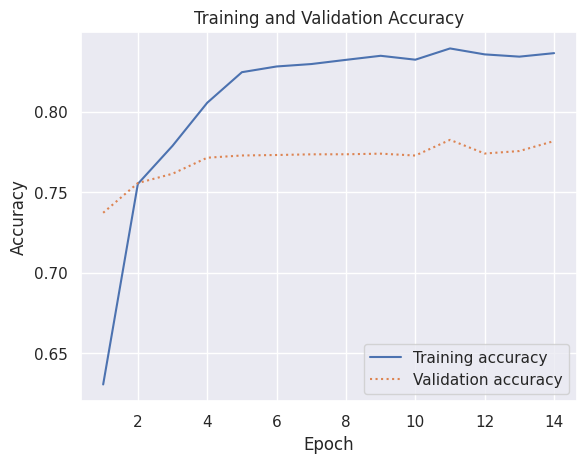

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [16]:
def translate_text(text, model, src_tokenizer, tar_tokenizer, tar_index_lookup, sequence_len):
    input_sequence = src_tokenizer.texts_to_sequences([text])
    padded_input_sequence = pad_sequences(input_sequence, maxlen=sequence_len, padding='post')
    decoded_text = '[start]'

    for i in range(sequence_len):
        target_sequence = tar_tokenizer.texts_to_sequences([decoded_text])
        padded_target_sequence = pad_sequences(target_sequence, maxlen=sequence_len, padding='post')[:, :-1]
        
        prediction = model([padded_input_sequence, padded_target_sequence])

        idx = np.argmax(prediction[0, i, :]) - 1
        token = tar_index_lookup[idx]
        decoded_text += ' ' + token

        if token == '[end]':
            break
    
    return decoded_text[8:-6] # Remove [start] and [end] tokens

tar_vocab = tar_tokenizer.word_index
tar_index_lookup = dict(zip(range(len(tar_vocab)), tar_vocab))

In [17]:
data = df[df['src_len'] <= 10]

In [18]:
test = data.sample(n=200, random_state=42)

In [19]:
input = test['source'].values

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
predicted = []
for text in input:
    translated = translate_text(text, model, src_tokenizer, tar_tokenizer,
                                tar_index_lookup, sequence_len)
    # predicted.append(translated)
    print(text)
    print(translated)
    break

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.

मार्स अटैक्स की एक् कॉमिक् साइंस फिक्सन हॉरर फिलम है
मार्स अटैक्स की एक कॉमिक साइंस फिक्शन हॉरर फिल्म है


In [24]:
# Save the model architecture to a JSON file
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights to a .h5 file
model.save_weights("model_weights.weights.h5")

print("Model architecture and weights have been saved.")

Model architecture and weights have been saved.


In [25]:
from tensorflow.keras.models import model_from_json

# Load the model architecture from the JSON file
with open("model_architecture.json", "r") as json_file:
    model_json = json_file.read()
loaded_model = model_from_json(model_json)

# Load the weights into the model
loaded_model.load_weights("model_weights.weights.h5")

print("Model architecture and weights have been successfully loaded.")

Model architecture and weights have been successfully loaded.


In [26]:
predicted = []
for text in input:
    translated = translate_text(text, loaded_model, src_tokenizer, tar_tokenizer,
                                tar_index_lookup, sequence_len)
    # predicted.append(translated)
    print(text)
    print(translated)
    break

मार्स अटैक्स की एक् कॉमिक् साइंस फिक्सन हॉरर फिलम है
मार्स अटैक्स की एक कॉमिक साइंस फिक्शन हॉरर फिल्म है


In [27]:
import pickle

# Save src_tokenizer
with open("src_tokenizer.pkl", "wb") as file:
    pickle.dump(src_tokenizer, file)

# Save tar_tokenizer
with open("tar_tokenizer.pkl", "wb") as file:
    pickle.dump(tar_tokenizer, file)

print("Tokenizers have been saved successfully.")


Tokenizers have been saved successfully.


In [28]:
with open("tar_index_lookup.pkl", "wb") as file:
    pickle.dump(tar_index_lookup, file)

In [23]:
test.iloc[0].target

'[start] मार्स अटैक्स की एक कॉमिक साइंस फिक्शन हॉरर फिल्म है [end]'

In [ ]:
test.drop(columns = ['src_len'], inplace = True)

In [ ]:
test = test.reset_index(drop=True)

In [ ]:
test['target'] = test['target'].str.replace('[start] ', '', regex=False).str.replace(' [end]', '', regex=False)

In [ ]:
test['predicted'] = predicted

In [ ]:
test['correct'] = test['target'] == test['predicted']

In [ ]:
test.head()

In [ ]:
accuracy = test['correct'].mean()

# Print the accuracy as a percentage
print(f'Accuracy: {accuracy * 100:.2f}%')